# Preprocess 

- load the fluxnet dataset and aggregate to daily intervals 

TODO: 
1. Fix the null/default negative values in the dataset [done]
2. Revert the copying of hr datasets [done]
3. Set up evaluation to do cross validation 

In [1]:
!mamba install -y -c conda-forge python-snappy openpyxl intake-parquet


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.8.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['python-snappy', 'openpyxl', 'intake-parquet']

conda-forge/linux-64     [<=>                 ] (00

In [2]:
# %load_ext lab_black

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [35]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client

import fsspec

from met_ml.data import cat
from met_ml.train.fluxnet_etl import load_fluxnet, get_meta, make_lookback


FOLDER = 's3://pangeo-scratch/cchiao/met-ml/'

In [4]:
client = Client(n_workers=2)
client

Client Scheduler: tcp://127.0.0.1:41781 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 32.14 GB


In [5]:
# TODO: put this dataset in cat
# also, there may be a new version of this...?

all_site_meta = pd.read_excel("../met_ml/data/FLX_AA-Flx_BIF_LATEST.xlsx").set_index(
    ["SITE_ID", "VARIABLE"]
)["DATAVALUE"]

all_site_meta.head()

SITE_ID  VARIABLE            
AR-SLu   MAP                                      400
         COUNTRY                            Argentina
         DOI                     10.18140/FLX/1440191
         DOI_DATAPRODUCT                  FLUXNET2015
         DOI_CONTRIBUTOR_NAME       Patricio Magliano
Name: DATAVALUE, dtype: object

In [6]:
df = load_fluxnet(cat, all_site_meta)

getting meta data
getting all jobs
computing
prep output
failed to read AU-Tum, look into this...
failed to read BR-Sa1, look into this...
failed to read DK-NuF, look into this...
failed to read DK-ZaF, look into this...
failed to read DK-ZaH, look into this...
failed to read FI-Lom, look into this...
failed to read NO-Adv, look into this...
failed to read NO-Blv, look into this...
failed to read RU-Sam, look into this...
failed to read RU-SkP, look into this...
failed to read RU-Tks, look into this...
failed to read RU-Vrk, look into this...
failed to read SE-St1, look into this...
failed to read US-Cop, look into this...
failed to read US-Ha1, look into this...
failed to read US-MMS, look into this...
failed to read US-Ne1, look into this...
failed to read US-Ne2, look into this...
failed to read US-Ne3, look into this...
failed to read US-PFa, look into this...
failed to read US-UMB, look into this...
failed to read ZA-Kru, look into this...
concat


In [7]:
df.head()

precip   t_min   t_max     SW_IN_F     LW_IN_F  \
Site   TIMESTAMP_START                                                   
AR-SLu 2009-01-01        3.072  18.632  23.105   79.239667  380.892000   
       2009-01-02        0.694  17.421  26.319  254.912292  369.231500   
       2009-01-03        0.000  16.709  30.400  342.819187  346.828625   
       2009-01-04        0.000  20.551  33.735  410.918083  338.023500   
       2009-01-05        0.986  21.835  32.551  306.377375  367.396125   

                             PA_F  RH  doy      lat      lon   elev  
Site   TIMESTAMP_START                                               
AR-SLu 2009-01-01       95.294625 NaN    1 -33.4648 -66.4598  508.0  
       2009-01-02       95.597354 NaN    2 -33.4648 -66.4598  508.0  
       2009-01-03       95.650583 NaN    3 -33.4648 -66.4598  508.0  
       2009-01-04       95.272437 NaN    4 -33.4648 -66.4598  508.0  
       2009-01-05       94.955813 NaN    5 -33.4648 -66.4598  508.0

In [8]:
df.count()
# missing RH 

precip     469351
t_min      469351
t_max      469351
SW_IN_F    469351
LW_IN_F    469351
PA_F       469351
RH         392470
doy        469351
lat        469351
lon        469351
elev       469351
dtype: int64

In [9]:
df.describe()

,precip,t_min,t_max,SW_IN_F,LW_IN_F,PA_F,RH,doy,lat,lon,elev
count,469351.000000,469351.000000,469351.000000,469351.000000,469351.000000,469351.000000,392470.000000,469351.000000,469351.000000,469351.000000,469351.000000
mean,2.237924,5.575293,14.528275,162.150505,310.704857,95.036415,71.517793,183.127107,39.244455,-17.374406,571.753554
std,6.468917,11.197103,12.441995,101.453720,57.191437,7.363686,19.196732,105.439826,22.222895,77.104116,709.257994
min,0.000000,-52.883000,-50.003000,0.000000,96.774875,59.154937,1.654000,1.000000,-37.425900,-157.408900,-9.000000
25%,0.000000,-0.539000,6.396500,72.711781,275.043542,93.127875,60.663714,92.000000,38.431600,-90.079900,124.000000
50%,0.000000,6.628000,15.520000,156.953875,313.304417,97.716250,75.046312,183.000000,45.562500,5.998080,270.000000
75%,1.396000,13.070000,23.820000,244.569417,348.239708,99.908333,86.009750,274.000000,50.893060,13.565160,705.000000
max,424.400000,32.537000,46.260000,431.894417,479.520833,106.376437,100.000000,366.000000,70.829140,161.341430,4313.000000


In [10]:
df.isnull().mean()

precip     0.000000
t_min      0.000000
t_max      0.000000
SW_IN_F    0.000000
LW_IN_F    0.000000
PA_F       0.000000
RH         0.163803
doy        0.000000
lat        0.000000
lon        0.000000
elev       0.000000
dtype: float64

In [11]:
# more or less every site has some null RH values 
for site, sub_df in df.groupby('Site'):
    print(site, sub_df.RH.isnull().mean())

AR-SLu 0.582648401826484
AR-Vir 0.45927446954141
AT-Neu 0.021901443504230962
AU-Ade 0.48996350364963503
AU-ASM 0.13526834611171962
AU-Cpr 0.17031763417305587
AU-Cum 0.2655109489051095
AU-DaP 0.167774736018772
AU-DaS 0.012123582323034806
AU-Dry 0.281971059835745
AU-Emr 0.17244525547445255
AU-Fog 0.19160583941605838
AU-Gin 0.2936344969199179
AU-GWW 0.012328767123287671
AU-How 0.2057500488949736
AU-Lox 0.5964432284541724
AU-RDF 0.4352189781021898
AU-Rig 0.007529089664613279
AU-Rob 0.0027397260273972603
AU-Stp 0.18068048494329292
AU-TTE 0.18156934306569342
AU-Wac 0.19164955509924708
AU-Whr 0.22861054072553047
AU-Wom 0.04819277108433735
AU-Ync 0.2737226277372263
BE-Bra 0.16138328530259366
BE-Lon 0.09507217521154804
BE-Vie 0.07435158501440922
BR-Sa3 0.3820470717022441
CA-Gro 0.1405430070727812
CA-NS1 0.24260679079956188
CA-NS2 0.2853231106243154
CA-NS3 0.43263964950711936
CA-NS4 0.2799452429842574
CA-NS5 0.21193866374589265
CA-NS6 0.21303395399780942
CA-NS7 0.19917864476386038
CA-Oas 0.02646

In [15]:
def plot_vars(df):
    fig, axes = plt.subplots(
        ncols=len(df.columns), nrows=1, sharex=True, figsize=(22, 4)
    )

    for ax, (key, s) in zip(axes, df.items()):
        s.plot(ax=ax)
        ax.set_title(key)
        
    plt.show()
    plt.close()

features


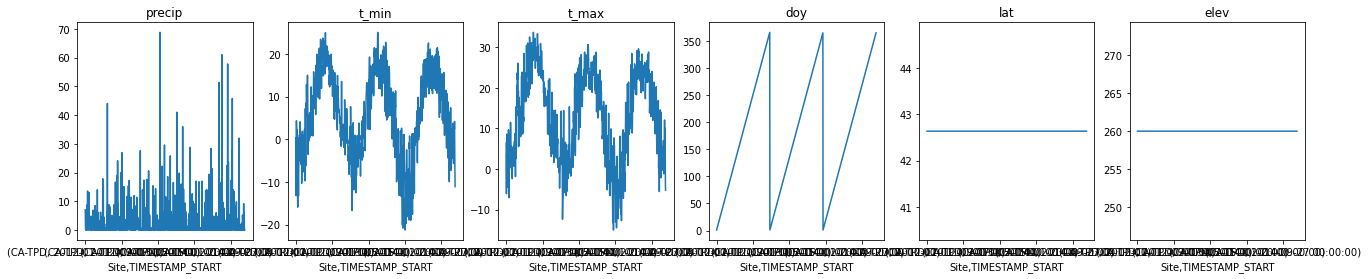

labels


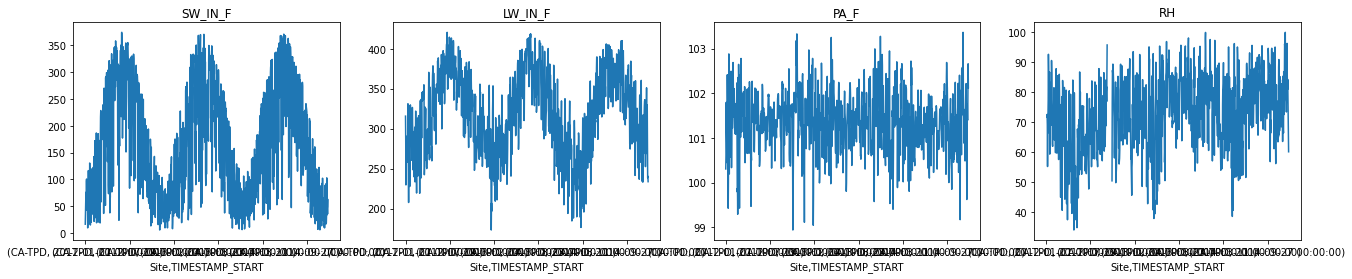

In [31]:
train_vars = ["precip", "t_min", "t_max", "doy", "lat", "elev"]
target_vars = ["SW_IN_F", "LW_IN_F", "PA_F", "RH"]

all_sites = df.index.get_level_values('Site').unique()
site = all_sites[random.randint(0, len(all_sites))]
print('features')
plot_vars(df.loc[df.index.get_level_values('Site') == site, train_vars])
print('labels')
plot_vars(df.loc[df.index.get_level_values('Site') == site, target_vars])

In [37]:
# save to a location
with fsspec.open(FOLDER + 'daily_data.csv', 'w') as f:
    df.to_csv(f)